In [1]:
import os
os.chdir("../..")

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
## TODO: for agent that has NO relevant data, we need to either
## 1) use contrastive only for shared buffer.
## 2) throw that away by distance thresholding.

In [4]:
use_contrastive = True
num_tasks = 4
num_init_tasks = 4
num_epochs = 40

In [5]:
seed_everything(0)

data_cfg = {
    "dataset_name": "mnist",
    "num_tasks": num_tasks,
    "num_train_per_task": 128,
    "num_val_per_task": 102,
    'remap_labels': True,
    'use_contrastive': use_contrastive,
}
dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [5 0 3 4 2 6 7 1 8 9]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [6]:
seed_everything(7)
sender_dataset1 = get_dataset(**data_cfg)

INFO:root:Class sequence: [9 5 7 8 4 3 6 1 0 2]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [7]:
seed_everything(9)
sender_dataset2 = get_dataset(**data_cfg)

INFO:root:Class sequence: [9 1 6 5 2 0 4 8 3 7]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [8]:
net_cfg = {
    'depth': num_init_tasks,
    'layer_size': 64,
    'num_init_tasks': num_init_tasks,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': num_tasks,
    'dropout': 0.0,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': use_contrastive,
    'save_dir': 'test',
}

In [9]:
NetCls = MLPSoftLLDynamic
LearnerCls = CompositionalDynamicER
AgentCls = RecvDataAgent
sharing_cfg = DictConfig({
    "scorer": "cross_entropy",
    "num_queries": 5,
    'num_data_neighbors': 5,
    # 'num_filter_neighbors': 2,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": 50,
})
train_cfg = {
    # "num_epochs": 40,
    "num_epochs": num_epochs,
}

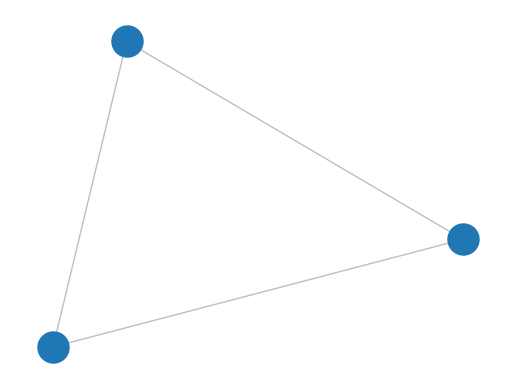

In [10]:
# create a graph of 3 nodes and 2 edges from 2 and 3 to 1
g = TopologyGenerator(num_nodes=3).generate_fully_connected()
TopologyGenerator.plot_graph(g)

In [11]:
fleet = Fleet(g, 0, [dataset, sender_dataset1, sender_dataset2], 
              sharing_cfg, AgentCls, NetCls, LearnerCls, net_cfg, agent_cfg, 
              train_cfg)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Created fleet with 3 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [12]:
for t in range(num_tasks):
    fleet.train(t)

INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69224913	acc: 0.524
INFO:root:	task: avg	loss: 0.69224913	acc: 0.524
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69224913	acc: 0.524
INFO:root:	task: avg	loss: 0.69224913	acc: 0.524
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.70603324	acc: 0.469
INFO:root:	task: avg	loss: 0.70603324	acc: 0.469
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.70603324	acc: 0.469
INFO:root:	task: avg	loss: 0.70603324	acc: 0.469
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69183442	acc: 0.529
INFO:root:	task: avg	loss: 0.69183442	acc: 0.529
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.69183442	acc: 0.529
INFO:root:	task: avg	loss: 0.69183442	acc: 0.529
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.69224913	acc: 0.524
INFO:root:	task: 1	lo

In [13]:
fleet.communicate(num_tasks-1)

In [14]:
receiver = fleet.agents[0]
inspect_task = 0

In [15]:
receiver.query[inspect_task].shape, receiver.incoming_data[1][inspect_task].shape, receiver.incoming_data[2][inspect_task].shape

(torch.Size([5, 1, 28, 28]),
 torch.Size([5, 5, 1, 28, 28]),
 torch.Size([5, 5, 1, 28, 28]))

In [16]:
query = receiver.query[inspect_task] # 5x1x28x28
neighbor_data1 = receiver.incoming_data[1][inspect_task]
neighbor_data2 = receiver.incoming_data[2][inspect_task]

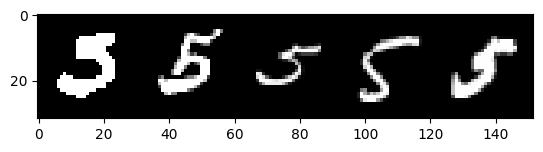

In [17]:
plt.imshow(make_grid(query).permute(1,2,0).cpu().numpy());

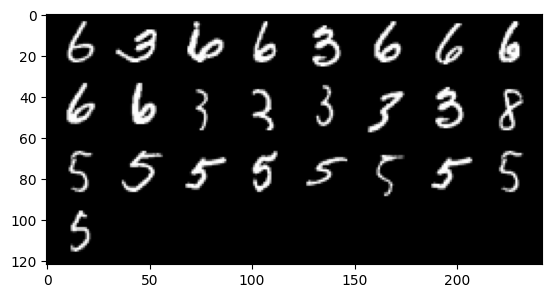

In [18]:
plt.imshow(make_grid(neighbor_data1.view(-1,1,28,28)).permute(1, 2, 0));

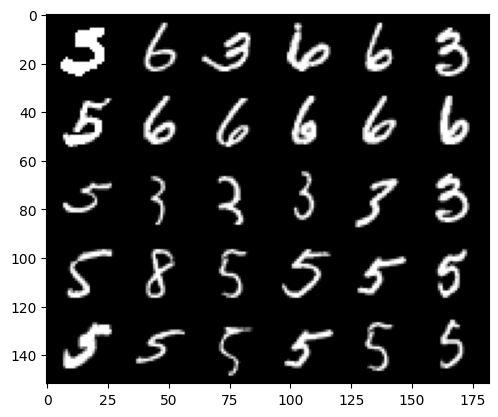

In [19]:
# plot neighbor_data1 along with the query
concat = torch.cat((query.unsqueeze(1), neighbor_data1), dim=1) # 5x6x1x28x28
n_queries = query.shape[0]
n_neighbors = neighbor_data2.shape[1]
grid_image = make_grid(concat.view(-1, 1, 28, 28), nrow=n_neighbors+1).permute(1, 2, 0)
plt.imshow(grid_image)
plt.show()

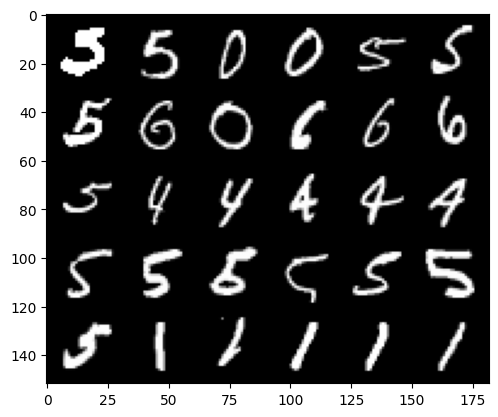

In [20]:
# plot neighbor_data1 along with the query
concat2 = torch.cat((query.unsqueeze(1), neighbor_data2), dim=1) # 5x6x1x28x28
n_queries = query.shape[0]
n_neighbors = neighbor_data2.shape[1]
grid_image = make_grid(concat2.view(-1, 1, 28, 28), nrow=n_neighbors+1).permute(1, 2, 0)
plt.imshow(grid_image)
plt.show()

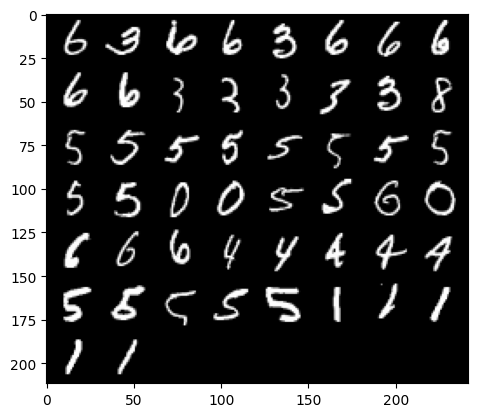

In [21]:
X,y,_ = receiver.agent.shared_replay_buffers[inspect_task].tensors
# NOTE: some incorrect img searches here. idk if this is going to hurt perf.
plt.imshow(make_grid(X).permute(1, 2, 0));